In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')
from misc.experiment_loader import *

folder_path = '../results/cifar10/vgg19bn_/first_experiment/data/'
full_experiment = FullExperiment(folder_path=folder_path)

## SGD

In [2]:
# SGD experiments

sgd_experiments = full_experiment.filter_parameters({'training_method': 'sgd',
                                                    'learning_method':'constant'})

# see all sgd experiments

print(sgd_experiments.len)


# we have 25 experiments in total, 7 for sgd without moment 7 for sgd with moment 
# 7 for sgd with nesterov moment and more 5 (4 new and 1 already presented among the 
# 7 from the sgd with nesterov moment) testing different nesterov moments with the best learning rate.





25


In [3]:
# Tests varying the learning rate and fixed momentum 

sgd_no_momentum = sgd_experiments.filter_parameters({'sgd_momentum':False})

sgd_momentum = sgd_experiments.filter_parameters({'sgd_momentum':0.9,
                                                  'sgd_nesterov':False})

sgd_nesterov = sgd_experiments.filter_parameters({'sgd_momentum':0.9,
                                                  'sgd_nesterov':True})

experiment_list = [sgd_no_momentum, sgd_momentum, sgd_nesterov]
names_list = ['SGD', 'SGD Momentum', 'SGD Nesterov']


for name,experiment in zip(names_list, experiment_list):
    

    print(experiment.make_latex_table(parameter_list=['sgd_lr'], 
                                      result_list=['val_acc1', 'val_loss'],
                                      result_type_list=['max_mean', 'min_mean'],
                                      name=name,
                                      precision=2))


\multirow{7}{*}{SGD}
 & 2 & 48.94 ($\pm$ 38.92) & 1.38 ($\pm$ 0.92) \\ 
 & 1 & 89.07 ($\pm$ 0.04) & 0.45 ($\pm$ 0.00) \\ 
 & 0.5 & 89.64 ($\pm$ 0.32) & 0.45 ($\pm$ 0.01) \\ 
 & 0.25 & 90.48 ($\pm$ 0.23) & 0.39 ($\pm$ 0.01) \\ 
 & 0.05 & 90.00 ($\pm$ 0.12) & 0.45 ($\pm$ 0.01) \\ 
 & 0.01 & 86.41 ($\pm$ 0.23) & 0.53 ($\pm$ 0.03) \\ 
 & 0.001 & 79.12 ($\pm$ 0.21) & 0.62 ($\pm$ 0.00) \\ 
\midrule 

\multirow{7}{*}{SGD Momentum}
 & 2 & 10.12 ($\pm$ 0.06) & 2.57 ($\pm$ 0.07) \\ 
 & 1 & 10.02 ($\pm$ 0.03) & 2.40 ($\pm$ 0.08) \\ 
 & 0.5 & 28.96 ($\pm$ 19.08) & 1.84 ($\pm$ 0.47) \\ 
 & 0.25 & 48.54 ($\pm$ 38.54) & 1.39 ($\pm$ 0.92) \\ 
 & 0.05 & 91.08 ($\pm$ 0.44) & 0.36 ($\pm$ 0.01) \\ 
 & 0.01 & 90.58 ($\pm$ 0.23) & 0.40 ($\pm$ 0.02) \\ 
 & 0.001 & 86.54 ($\pm$ 0.34) & 0.52 ($\pm$ 0.02) \\ 
\midrule 

\multirow{7}{*}{SGD Nesterov}
 & 2 & 10.04 ($\pm$ 0.00) & 2.56 ($\pm$ 0.21) \\ 
 & 1 & 10.06 ($\pm$ 0.03) & 2.41 ($\pm$ 0.05) \\ 
 & 0.5 & 10.02 ($\pm$ 0.04) & 2.31 ($\pm$ 0.00) \\ 
 & 0.25 & 86

In [4]:
# Tests varying the momentum and fixing the learning rate.

sgd_test_momentum = sgd_experiments.filter_parameters({'sgd_lr':0.05, 'sgd_nesterov':True})
sgd_test_momentum.sort_by_parameter('sgd_momentum', reverse=False)

print(sgd_test_momentum.make_latex_table(parameter_list=['sgd_momentum'], 
                                      result_list=['val_acc1', 'val_loss'],
                                      result_type_list=['max_mean', 'min_mean'],
                                      name='SGD Nesterov',
                                      precision=2))

\multirow{5}{*}{SGD Nesterov}
 & 0.1 & 89.92 ($\pm$ 0.43) & 0.45 ($\pm$ 0.01) \\ 
 & 0.3 & 90.31 ($\pm$ 0.13) & 0.42 ($\pm$ 0.00) \\ 
 & 0.5 & 90.50 ($\pm$ 0.23) & 0.41 ($\pm$ 0.01) \\ 
 & 0.7 & 90.84 ($\pm$ 0.13) & 0.39 ($\pm$ 0.01) \\ 
 & 0.9 & 90.85 ($\pm$ 0.29) & 0.37 ($\pm$ 0.00) \\ 
\midrule 



## ADAM

In [5]:
# adam experiments

adam_experiments = full_experiment.filter_parameters({'training_method': 'adam',
                                                    'learning_method':'constant'})

# see all adam experiments

print(adam_experiments.len)

# for experiment in adam_experiments.list:
#     print(experiment.parameters_dict)
#     print('\n')
    
    
# 12 tests 6 with amsgrad and 6 without.

12


In [6]:
adam_amsgrad = adam_experiments.filter_parameters({'adam_amsgrad':True})

adam_no_amsgrad = adam_experiments.filter_parameters({'adam_amsgrad':False})

experiment_list = [adam_no_amsgrad, adam_amsgrad]
names_list = ['ADAM', 'ADAM amsgrad']


for name,experiment in zip(names_list, experiment_list):
    

    print(experiment.make_latex_table(parameter_list=['adam_lr'], 
                                      result_list=['val_acc1', 'val_loss'],
                                      result_type_list=['max_mean', 'min_mean'],
                                      name=name,
                                      precision=3))

\multirow{6}{*}{ADAM}
 & 0.005 & 90.365 ($\pm$ 0.255) & 0.408 ($\pm$ 0.007) \\ 
 & 0.001 & 91.080 ($\pm$ 0.10) & 0.382 ($\pm$ 0.004) \\ 
 & 0.0005 & 91.130 ($\pm$ 0.340) & 0.380 ($\pm$ 0.020) \\ 
 & 0.0003 & 90.995 ($\pm$ 0.045) & 0.388 ($\pm$ 0.018) \\ 
 & 0.0001 & 88.775 ($\pm$ 0.125) & 0.455 ($\pm$ 0.002) \\ 
 & 5e-05 & 86.190 ($\pm$ 0.190) & 0.529 ($\pm$ 0.009) \\ 
\midrule 

\multirow{6}{*}{ADAM amsgrad}
 & 0.005 & 90.610 ($\pm$ 0.230) & 0.403 ($\pm$ 0.014) \\ 
 & 0.001 & 91.030 ($\pm$ 0.270) & 0.380 ($\pm$ 0.010) \\ 
 & 0.0005 & 91.20 ($\pm$ 0.290) & 0.379 ($\pm$ 0.009) \\ 
 & 0.0003 & 90.895 ($\pm$ 0.105) & 0.385 ($\pm$ 0.011) \\ 
 & 0.0001 & 87.970 ($\pm$ 0.050) & 0.466 ($\pm$ 0.002) \\ 
 & 5e-05 & 85.570 ($\pm$ 0.140) & 0.548 ($\pm$ 0.009) \\ 
\midrule 



## RMSPROP

In [7]:
# rmsprop experiments

rmsprop_experiments = full_experiment.filter_parameters({'training_method': 'rmsprop',
                                                    'learning_method':'constant'})

# see all rmsprop experiments

print(rmsprop_experiments.len)
    
# 12 tests 6 with centered rmsprop and 6 without.

12


In [8]:
rmsprop_centered = rmsprop_experiments.filter_parameters({'rmsprop_centered':True})

rsmprop_not_centered = rmsprop_experiments.filter_parameters({'rmsprop_centered':False})

experiment_list = [rsmprop_not_centered, rmsprop_centered]
names_list = ['RMSPROP', 'RMSPROP centered']


for name,experiment in zip(names_list, experiment_list):
    

    print(experiment.make_latex_table(parameter_list=['rmsprop_lr'], 
                                      result_list=['val_acc1', 'val_loss'],
                                      result_type_list=['max_mean', 'min_mean'],
                                      name=name,
                                      precision=3))

\multirow{6}{*}{RMSPROP}
 & 0.01 & 89.850 ($\pm$ 0.010) & 0.421 ($\pm$ 0.001) \\ 
 & 0.005 & 90.020 ($\pm$ 0.170) & 0.430 ($\pm$ 0.018) \\ 
 & 0.001 & 90.805 ($\pm$ 0.155) & 0.410 ($\pm$ 0.003) \\ 
 & 0.0005 & 90.950 ($\pm$ 0.080) & 0.386 ($\pm$ 0.011) \\ 
 & 0.0003 & 90.610 ($\pm$ 0.250) & 0.402 ($\pm$ 0.005) \\ 
 & 0.0001 & 89.210 ($\pm$ 0.010) & 0.458 ($\pm$ 0.014) \\ 
\midrule 

\multirow{6}{*}{RMSPROP centered}
 & 0.01 & 90.305 ($\pm$ 0.215) & 0.434 ($\pm$ 0.003) \\ 
 & 0.005 & 90.370 ($\pm$ 0.140) & 0.433 ($\pm$ 0.015) \\ 
 & 0.001 & 90.655 ($\pm$ 0.425) & 0.412 ($\pm$ 0.009) \\ 
 & 0.0005 & 90.720 ($\pm$ 0.030) & 0.386 ($\pm$ 0.013) \\ 
 & 0.0003 & 90.815 ($\pm$ 0.215) & 0.408 ($\pm$ 0.018) \\ 
 & 0.0001 & 88.955 ($\pm$ 0.045) & 0.465 ($\pm$ 0.003) \\ 
\midrule 



## ADAGRAD

In [9]:
# adagrad experiments

adagrad_experiments = full_experiment.filter_parameters({'training_method': 'adagrad',
                                                    'learning_method':'constant'})

# see all sgd experiments

print(adagrad_experiments.len)

# for experiment in adagrad_experiments.list:
#     print(experiment.parameters_dict)
#     print('\n')
    
# 5 tests

5


In [10]:
experiment_list = [adagrad_experiments]
names_list = ['ADAGRAD']


for name,experiment in zip(names_list, experiment_list):
    

    print(experiment.make_latex_table(parameter_list=['adagrad_lr'], 
                                      result_list=['val_acc1', 'val_loss'],
                                      result_type_list=['max_mean', 'min_mean'],
                                      name=name,
                                      precision=3))

\multirow{5}{*}{ADAGRAD}
 & 0.1 & 89.190 ($\pm$ 0.160) & 0.447 ($\pm$ 0.017) \\ 
 & 0.05 & 89.40 ($\pm$ 0.310) & 0.425 ($\pm$ 0.005) \\ 
 & 0.01 & 88.770 ($\pm$ 0.090) & 0.440 ($\pm$ 0.014) \\ 
 & 0.0075 & 88.395 ($\pm$ 0.025) & 0.440 ($\pm$ 0.011) \\ 
 & 0.005 & 87.805 ($\pm$ 0.095) & 0.452 ($\pm$ 0.006) \\ 
\midrule 



## TAS

In [11]:
# TAS experiments

tas_experiments = full_experiment.filter_parameters({'training_method': 'sgd',
                                                    'learning_method':'tas'})

# see all sgd experiments

print(tas_experiments.len)

# for experiment in tas_experiments.list:
#     print(experiment.parameters_dict['sgd_lr'])
#     print('\n')
    
# 63 tests, 9 for each epoch selected(100, 50, 25, 15, 10, 5. 100 repets twice. we will disconsidere the first batch)



63
0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05


0.05




In [12]:
tas_100 = tas_experiments.filter_parameters({'epochs':100})
tas_10 = tas_experiments.filter_parameters({'epochs':10})
tas_5 = tas_experiments.filter_parameters({'epochs':5})
tas_100.list = tas_100.list[9:]

experiment_list = [tas_100]
names_list = ['TAS']


for name,experiment in zip(names_list, experiment_list):
    
    print(experiment.make_latex_table(parameter_list=['tas_alpha', 'tas_beta'], 
                                      result_list=['val_acc1', 'val_loss'],
                                      result_type_list=['max_mean', 'min_mean'],
                                      name=name,
                                      precision=2))


\multirow{18}{*}{TAS}
 & 10 & 0.3 & 91.08 ($\pm$ 0.01) & 0.38 ($\pm$ 0.01) \\ 
 & 10 & 0.5 & 91.52 ($\pm$ 0.27) & 0.37 ($\pm$ 0.01) \\ 
 & 10 & 0.7 & 91.74 ($\pm$ 0.24) & 0.38 ($\pm$ 0.01) \\ 
 & 25 & 0.3 & 91.24 ($\pm$ 0.00) & 0.36 ($\pm$ 0.00) \\ 
 & 25 & 0.5 & 91.74 ($\pm$ 0.12) & 0.36 ($\pm$ 0.01) \\ 
 & 25 & 0.7 & 91.97 ($\pm$ 0.08) & 0.36 ($\pm$ 0.01) \\ 
 & 50 & 0.3 & 91.47 ($\pm$ 0.02) & 0.34 ($\pm$ 0.00) \\ 
 & 50 & 0.5 & 91.56 ($\pm$ 0.20) & 0.38 ($\pm$ 0.01) \\ 
 & 50 & 0.7 & 91.74 ($\pm$ 0.04) & 0.38 ($\pm$ 0.01) \\ 
\midrule 



In [13]:
experiment_list = [tas_experiments]
names_list = ['TAS']


for name,experiment in zip(names_list, experiment_list):
    

    print(experiment.make_latex_table(parameter_list=['tas_alpha'], 
                                      result_list=['val_acc1', 'val_loss'],
                                      result_type_list=['max_mean', 'min_mean'],
                                      name=name,
                                      precision=3))

\multirow{63}{*}{TAS}
 & 10 & 91.065 ($\pm$ 0.155) & 0.376 ($\pm$ 0.003) \\ 
 & 10 & 91.445 ($\pm$ 0.145) & 0.386 ($\pm$ 0.003) \\ 
 & 10 & 91.535 ($\pm$ 0.135) & 0.376 ($\pm$ 0.011) \\ 
 & 25 & 91.205 ($\pm$ 0.455) & 0.366 ($\pm$ 0.004) \\ 
 & 25 & 91.50 ($\pm$ 0.10) & 0.375 ($\pm$ 0.009) \\ 
 & 25 & 91.705 ($\pm$ 0.175) & 0.374 ($\pm$ 0.001) \\ 
 & 50 & 91.045 ($\pm$ 0.235) & 0.374 ($\pm$ 0.001) \\ 
 & 50 & 91.465 ($\pm$ 0.025) & 0.372 ($\pm$ 0.018) \\ 
 & 50 & 91.640 ($\pm$ 0.320) & 0.371 ($\pm$ 0.003) \\ 
 & 10 & 86.740 ($\pm$ 0.360) & 0.422 ($\pm$ 0.005) \\ 
 & 10 & 89.590 ($\pm$ 0.210) & 0.385 ($\pm$ 0.002) \\ 
 & 10 & 88.855 ($\pm$ 0.145) & 0.370 ($\pm$ 0.015) \\ 
 & 10 & 90.625 ($\pm$ 0.165) & 0.375 ($\pm$ 0.00) \\ 
 & 10 & 89.175 ($\pm$ 0.115) & 0.362 ($\pm$ 0.00) \\ 
 & 10 & 91.00 ($\pm$ 0.310) & 0.362 ($\pm$ 0.004) \\ 
 & 25 & 86.150 ($\pm$ 0.220) & 0.422 ($\pm$ 0.003) \\ 
 & 25 & 89.580 ($\pm$ 0.070) & 0.344 ($\pm$ 0.001) \\ 
 & 25 & 89.115 ($\pm$ 0.065) & 0.348 ($\pm$ 0.00

## Best Results

In [14]:
sgd_experiments.sort_by_results('val_acc1', 'max_mean', reverse=True)
adagrad_experiments.sort_by_results('val_acc1', 'max_mean', reverse=True)
adam_experiments.sort_by_results('val_acc1', 'max_mean', reverse=True)
rmsprop_experiments.sort_by_results('val_acc1', 'max_mean', reverse=True)
tas_100.sort_by_results('val_acc1', 'max_mean', reverse=True)

best_list = [sgd_experiments.list[0], 
             adagrad_experiments.list[0], 
             adam_experiments.list[0], 
             rmsprop_experiments.list[0],
             tas_100.list[0]]

(<Figure size 936x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fce62240278>)

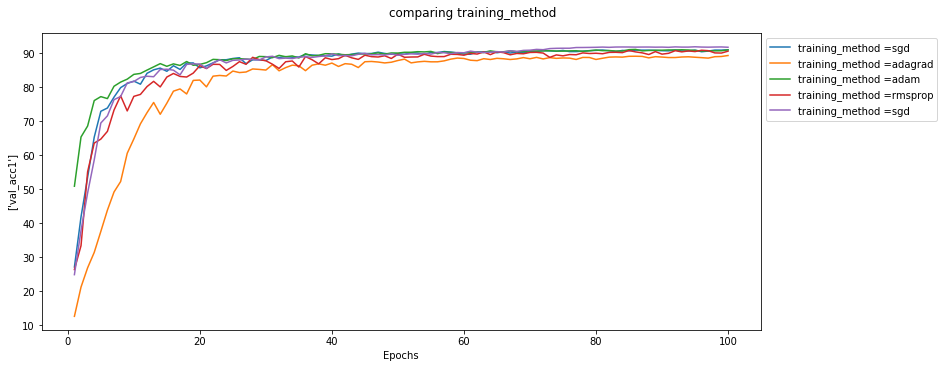

In [15]:
best_experiments = FullExperiment(experiment_list=best_list)
best_experiments.plot_compare_graph(parameters_to_compare=['training_method'], result_to_compare=['val_acc1'])

In [16]:
experiment_list = [best_experiments]
names_list = ['Best']


for name,experiment in zip(names_list, experiment_list):
    
    print(experiment.make_latex_table(parameter_list=['training_method'], 
                                      result_list=['val_acc1', 'val_loss'],
                                      result_type_list=['max_mean', 'min_mean'],
                                      name=name,
                                      precision=2))

\multirow{5}{*}{Best}
 & sgd & 91.08 ($\pm$ 0.44) & 0.36 ($\pm$ 0.01) \\ 
 & adagrad & 89.40 ($\pm$ 0.31) & 0.42 ($\pm$ 0.01) \\ 
 & adam & 91.20 ($\pm$ 0.29) & 0.38 ($\pm$ 0.01) \\ 
 & rmsprop & 90.95 ($\pm$ 0.08) & 0.39 ($\pm$ 0.01) \\ 
 & sgd & 91.97 ($\pm$ 0.08) & 0.36 ($\pm$ 0.01) \\ 
\midrule 



## 5 and 10 epochs

In [17]:
experiments_list = [sgd_experiments, rmsprop_experiments, adagrad_experiments, adam_experiments, tas_10]
best_list = []
for experiments in experiments_list:
    experiments.sort_by_results('val_acc1', 'max_mean', reverse=True, epoch_limit=10)
    best_list.append(experiments.list[0])

for experiment in best_list:
    print(experiment.experiment_results(epoch_limit=10)['val_acc1']['mean'])
#     print(experiment.parameters_dict)
    print('\n')
    


# adagrad_experiments.sort_by_results('val_acc1', 'max_mean', reverse=True, epoch_lim=10)
# adam_experiments.sort_by_results('val_acc1', 'max_mean', reverse=True, epoch_lim=10)
# rmsprop_experiments.sort_by_results('val_acc1', 'max_mean', reverse=True, epoch_lim=10)

# # sgd_experiments.list[0].experiment_results(epoch_limit=10)['val_acc1']['mean']


[57.615 69.06  74.545 77.135 79.625 79.195 79.165 82.8   83.69  82.87 ]


[26.345 44.435 60.485 70.36  72.79  68.035 76.365 78.62  77.21  79.565]


[28.08  46.69  53.185 60.245 67.48  69.455 71.375 76.895 77.835 79.56 ]


[50.91  65.41  68.635 76.13  77.295 76.715 80.35  81.575 82.435 83.845]


[24.135 36.675 47.9   55.125 67.96  71.26  75.73  79.095 81.73  83.885]




In [18]:
best_experiments = FullExperiment(experiment_list=best_list)
experiment_list = [best_experiments]
names_list = ['Best']


for name,experiment in zip(names_list, experiment_list):
    
    print(experiment.make_latex_table(parameter_list=['training_method'], 
                                      result_list=['val_acc1', 'val_loss'],
                                      result_type_list=['max_mean', 'min_mean'],
                                      name=name,
                                      epoch_limit=10,  
                                      precision=2))

\multirow{5}{*}{Best}
 & sgd & 83.69 ($\pm$ 0.45) & 0.50 ($\pm$ 0.02) \\ 
 & rmsprop & 79.56 ($\pm$ 0.05) & 0.63 ($\pm$ 0.00) \\ 
 & adagrad & 79.56 ($\pm$ 0.63) & 0.61 ($\pm$ 0.01) \\ 
 & adam & 83.84 ($\pm$ 0.39) & 0.51 ($\pm$ 0.02) \\ 
 & sgd & 83.88 ($\pm$ 0.87) & 0.48 ($\pm$ 0.02) \\ 
\midrule 



In [19]:
print(sgd_experiments.make_latex_table(parameter_list=['sgd_lr'], 
                                       result_list=['val_acc1', 'val_loss'],
                                       result_type_list=['max_mean'],
                                       name='SGD Momentum',
                                       precision=2))

\multirow{25}{*}{SGD Momentum}
 & 0.01 & 90.52 ($\pm$ 0.27) \\ 
 & 0.01 & 90.58 ($\pm$ 0.23) \\ 
 & 0.05 & 90.84 ($\pm$ 0.13) \\ 
 & 0.05 & 91.08 ($\pm$ 0.44) \\ 
 & 0.05 & 90.50 ($\pm$ 0.23) \\ 
 & 0.05 & 90.31 ($\pm$ 0.13) \\ 
 & 0.05 & 89.92 ($\pm$ 0.43) \\ 
 & 0.05 & 90.85 ($\pm$ 0.29) \\ 
 & 0.05 & 90.00 ($\pm$ 0.12) \\ 
 & 0.001 & 86.54 ($\pm$ 0.34) \\ 
 & 0.001 & 86.29 ($\pm$ 0.23) \\ 
 & 0.25 & 90.48 ($\pm$ 0.23) \\ 
 & 0.01 & 86.41 ($\pm$ 0.23) \\ 
 & 0.5 & 89.64 ($\pm$ 0.32) \\ 
 & 0.001 & 79.12 ($\pm$ 0.21) \\ 
 & 1 & 89.07 ($\pm$ 0.04) \\ 
 & 2 & 48.94 ($\pm$ 38.92) \\ 
 & 0.25 & 86.06 ($\pm$ 0.09) \\ 
 & 0.25 & 48.54 ($\pm$ 38.54) \\ 
 & 0.5 & 28.96 ($\pm$ 19.08) \\ 
 & 2 & 10.12 ($\pm$ 0.06) \\ 
 & 1 & 10.06 ($\pm$ 0.03) \\ 
 & 1 & 10.02 ($\pm$ 0.03) \\ 
 & 0.5 & 10.02 ($\pm$ 0.04) \\ 
 & 2 & 10.04 ($\pm$ 0.00) \\ 
\midrule 



In [9]:
sgd_experiments.show_results('T&L', ['train_acc1', 'val_acc1'], ['max_mean'])


---------- EXPERIMENT 0 ----------
*** PARAMETERS ***
training method:  sgd
sgd_lr :  2
sgd_momentum :  0.9
sgd_weight_decay :  0
sgd_dampening :  0
sgd_nesterov :  True
learning method:  constant
*** RESULTS ***
train_acc1 10.326
val_acc1 10.04
---------- EXPERIMENT 1 ----------
*** PARAMETERS ***
training method:  sgd
sgd_lr :  2
sgd_momentum :  0.9
sgd_weight_decay :  0
sgd_dampening :  0
sgd_nesterov :  False
learning method:  constant
*** RESULTS ***
train_acc1 10.212
val_acc1 10.120000000000001
---------- EXPERIMENT 2 ----------
*** PARAMETERS ***
training method:  sgd
sgd_lr :  1
sgd_momentum :  0.9
sgd_weight_decay :  0
sgd_dampening :  0
sgd_nesterov :  True
learning method:  constant
*** RESULTS ***
train_acc1 10.258
val_acc1 10.059999999999999
---------- EXPERIMENT 3 ----------
*** PARAMETERS ***
training method:  sgd
sgd_lr :  1
sgd_momentum :  0.9
sgd_weight_decay :  0
sgd_dampening :  0
sgd_nesterov :  False
learning method:  constant
*** RESULTS ***
train_acc1 10.428
val

In [10]:
sgd_experiments.list

In [153]:
a = {'a':'1', 'b':'2'}
for key, value in a.items():
    a[key] = int(value)

In [154]:
a

{'a': 1, 'b': 2}

In [223]:
'{{{}}}'.format(1)

'{1}'